In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# CNN Cancer Detection Kaggle Mini Project
The goal of this mini project is to detect metastatic cancer which is a cancer that has spread from another part of the body and has the same type of cancer cells. The Kaggle competition data consists of a set of training image files in a train directory, a set of test image files in a test directory, and a train_labels.csv file with two fields: one with the file name, and the other with a label indifcating if it is positive for cancer or negative. The images are color 96x96 pixel. This project used PyTorch for the CNN, scikit-learn to split the data into training and validation data sets, and Pandas for exploratory analysis.

# Exploratory Data Analysis


There are 22025 training images. This is shown by counting how many rows are in the train_labels.csv file which matches the number of files in the train directory. 59% (or 130908) of the images are cancer free and 41% (or 89117) of the images show cancer. The original data set had a 50/50 split between positive and negative classes, however, since the kaggle version of the data set removed duplicates this ratio was not maintained. This does not represent a large class imbalance and this distribution should work fine for training purposes. A small sample of positive and negative images are displayed mostly to validate that the images were loaded successfully since visual inspection doesn't help a non-expert see why an image contains cancer or not (i.e. it is not like visually inspecting if an image is a cat or a dog!).

In [2]:
import numpy as np
import pandas as pd
import os

# setup varaibles for data directory and directories containing train and test data

base_dir = '/Users/Shared/kaggle/input/histopathologic-cancer-detection/'
labels = pd.read_csv(base_dir + 'train_labels.csv')
annotations_file = base_dir + 'train_labels.csv'
sub = pd.read_csv(base_dir + 'sample_submission.csv')
train_path = base_dir + 'train/'
test_path = base_dir + 'test/'


# load the files of annotations that tell us what training images are positive or negative
train_labels = pd.read_csv(annotations_file, dtype=str)


# we use the training_lables to determine how many observations we have and the class distribution
print("Number of files in the train directory", len(os.listdir(train_path)))
print("Number of files in the test directory", len(os.listdir(test_path)))



Number of files in the train directory 220025
Number of files in the test directory 57458


The train_labels.csv file has a field called label where the 1 value indicates the presence of cancer and the value of 0 indicates no cancer is present. The distribution of positive and negative are shown in the following diagrams.

In [3]:
train_labels.describe()

,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835,0
freq,1,130908


In [4]:
label_counts = train_labels['label'].value_counts()
print(label_counts)
print(label_counts.iloc[0])

label
0    130908
1     89117
Name: count, dtype: int64
130908


<Axes: title={'center': 'Cancer Image Class Frequency'}, xlabel='Class', ylabel='Frequency'>

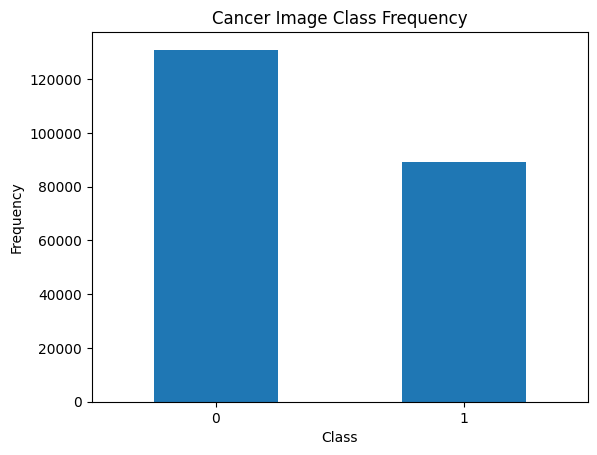

In [5]:
label_counts.plot.bar(rot=0, title = "Cancer Image Class Frequency", xlabel = "Class", ylabel = "Frequency")

<Axes: title={'center': 'Class percetage'}, ylabel='count'>

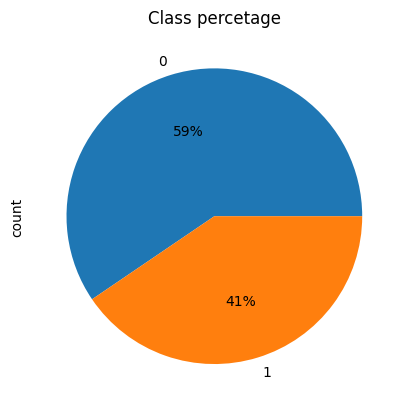

In [6]:
label_counts.plot.pie(title='Class percetage', autopct='%1.0f%%')

## Cancer Negative Images
It is impractical to look at every image, however, let's take a look at a three cancer negative images.

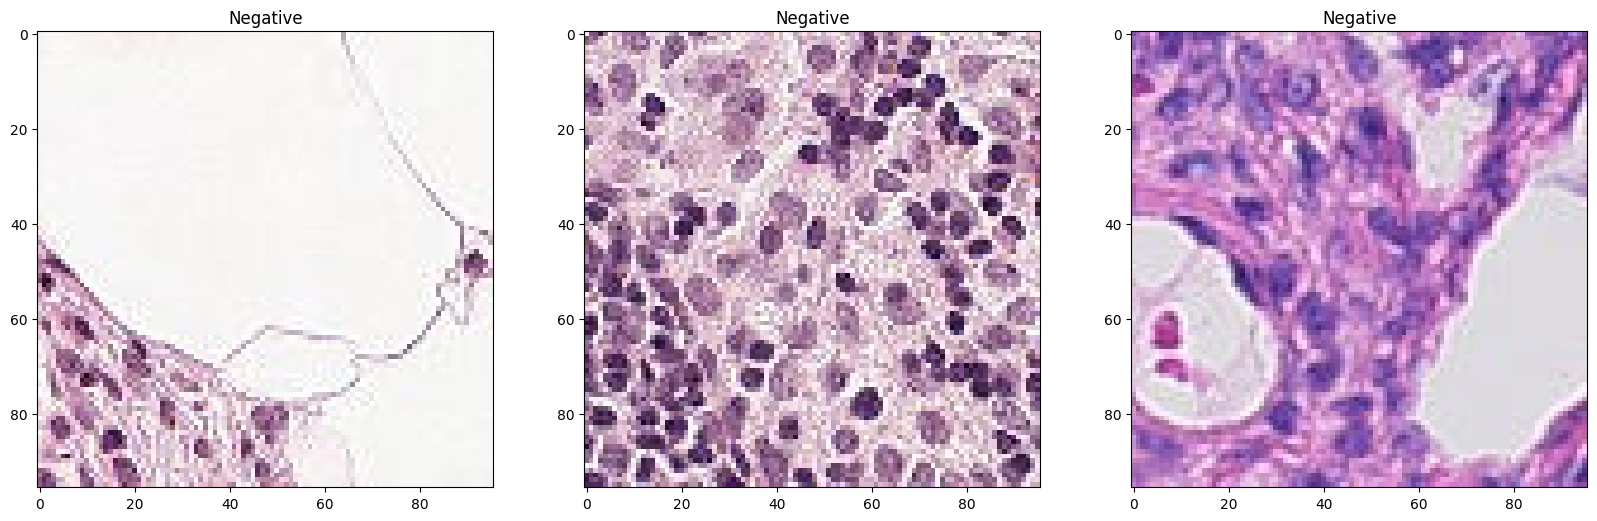

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

neg = train_labels[train_labels['label'] == '0']

fig, ax = plt.subplots(1, 3,figsize=(20,20))

for i in range(0, 3):
    ax = plt.subplot(1, 3, i+1)
    filename = neg['id'].iloc[i]
    img = mpimg.imread(f'{train_path}{filename}.tif')
    ax.imshow(img)
    ax.set_title('Negative')

## Cancer Positive Images
The following are three cancer positive images.

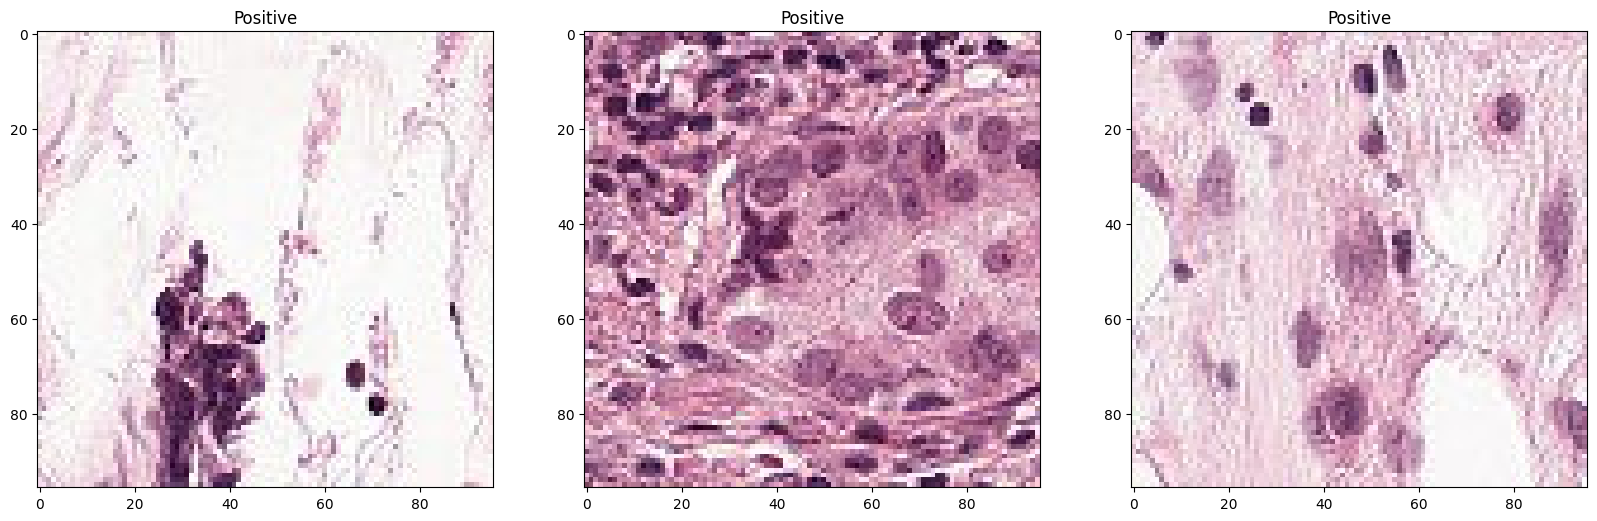

In [8]:
pos = train_labels[train_labels['label'] == '1']
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i in range(0, 3):
    ax = plt.subplot(1, 3, i + 1)
    filename = pos['id'].iloc[i]
    img = mpimg.imread(f'{train_path}{filename}.tif')
    ax.imshow(img)
    ax.set_title('Positive')
#


#  Data Preprocessing using Pytorch

## Using subsets of data to speed up model training and evaluation

CancerImageTifDataset wich is a subclass of Dataset to perform data sampling, basic transformation, and data augmentation. The option to select smaller datasets for training was used to speed up experimentation with different model architectures, data augementation, and hyperparameters because training on the full data set takes a long time. The premise is that using smaller data sets could give faster feedback on what combination might be more promissing. Once a better hypothesis is framed, then a the full data set is used for training.

Two dataset size are using:
1. small: 5000 trainin observations and 1000 validation observations
2. full: all training observations and all validation observations (80 / 20 training data split is used)

## Data tranformations and data augmentation

Two type of transofrmation used and tested. 
1. min_transforms: basic un-augmented data transformation that that simply transforms the data into a Tensor that Pytorch expects and normlizes the values. i
2. pytotch_recomended_transforms: data augmentation transformation recommeneded by Pytorch for binary image classification. It randomly crops and horizontally flips each image. This is common practice to help the CNN generalize better to different images variations. This can be more complex than what is used here, however, I decided to go with the Pytorch recommended data augmentation and try to compare the model performnace when using the basic tranformation vs the augmented data transformation.





In [9]:
import math
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [10]:
#Splitting data into train and val
train, val = train_test_split(labels, stratify=labels.label, test_size=0.2)
len(train), len(val)

(176020, 44005)

In [11]:
class CancerImageTifDataset(Dataset):
    def __init__(self, df, data_dir = './', transform=None, subset_size=None):
        super().__init__()
        self.df_values = df.values
        if subset_size is not None:
            idx = np.random.randint(self.df_values.shape[0], size=subset_size)
            new_df_values = self.df_values[idx, :]
            self.df_values = new_df_values


        self.data_dir = data_dir
        self.transform = transform
        print('Final data set size is ',self.df_values.shape[0])

    def __len__(self):
        return len(self.df_values)
    
    def __getitem__(self, index):
        img_name,label = self.df_values[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = Image.open(img_path)
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [12]:
min_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




# pytorch recommended classification transform
# https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html
# we to convert it to a tensor. The deprecated method "ToTensor" works but it not in this code example.
# the code example does not work as is and it produces an error that Normalize does not support PIL images
# so we will convert it to a tensor by using v2.ToImage and the ToDtype
pytorch_recommended_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(96, 96), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [13]:
def build_data_loaders(train,  val, train_path, 
                       test_path, batch_size, transforms, 
                       train_subset_size=None, val_subset_size=None):
    if train_subset_size :
        dataset_train = CancerImageTifDataset(train, data_dir=train_path, 
                                              transform=min_transforms, 
                                              subset_size=train_subset_size)
    else :
        dataset_train = CancerImageTifDataset(train, data_dir=train_path, 
                                              transform=min_transforms)
    if val_subset_size :
        dataset_valid = CancerImageTifDataset(val, data_dir=train_path, 
                                              transform=min_transforms, 
                                              subset_size=val_subset_size)
    else :
        dataset_valid = CancerImageTifDataset(val, data_dir=train_path, 
                                              transform=min_transforms)

    loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)

    data_loader = [loader_train, loader_valid]

    sub_data_set = CancerImageTifDataset(sub, data_dir=test_path, transform=min_transforms)
    sub_data_loader = DataLoader(dataset = sub_data_set, batch_size=batch_size, shuffle=False, num_workers=0)

    return data_loader, sub_data_loader


# CNN Architecture using Pytorch

Two CNNs are compared: 
- CNN_1: 3 hidden layers, the first layer has an output of 32 and the output size double for each layer. MaxPooling is used after each layer and a global Average Pool is used at the end.
- CNN_2: same as CNN_1, however the cpacity is doubled to 6 layers

CNN architectures commonly adopt both Max Pooling and Global Average Pooling which is applied right before the final layer, i.e. almost at the end. Pooling reduces the feature map size, extracts the dominant features, and regularizes the CNN which in turns reduces overfitting. Average Pooling help the model adapt to different image shapes and so it is very commonly used. See https://www.kdnuggets.com/diving-into-the-pool-unraveling-the-magic-of-cnn-pooling-layers for more insight.

Initialy, no padding or strides where used. It was found that eventually there was too much image reduction without the padding and it has to be used in order to build larger CNNs. After more research, if you don't have padding the training process loses the edges. For this reason, padding was use all the time. The reason why stride was eventually used was to help speed up training time, especially for CNN_2. 

Adam is used for the optimizer which is the most common optimzer used for CNNs. CrossEntropy is used for the Loss Function, again, because it is a very commonly used loss function for CNNs.

In [14]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.final = nn.Linear(128*6*6, 2) # !!!
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pooling(x)
        #print("x.shape",x.shape)

        x = x.view(-1, 128*6*6) # !!!
        x = self.final(x)
        return x

In [15]:
def train_cnn(model, data_loader, num_epochs, criterian, optimizer):
    epoch_loss = np.empty((2, num_epochs)) 
    epoch_acc  = np.empty((2, num_epochs)) 

    for epoch in range(num_epochs):
        accumulated_loss = [0.0, 0.0]
        accumulated_correct = [0.0, 0.0]
        total_samples = [0,0]

        for phase in range(2):
            if phase == 0:
                model.train(True)  # Set model to training mode
            
            else:
                model.train(False)  # Set model to evaluate mode

            for i, (images, labels) in enumerate(data_loader[phase]):
                #print('phase:', phase, 'epoch:', epoch)
                images = images.to(device)
                labels = labels.to(device)
                current_batch_size, c, h, w = images.shape
                #print("batch size", current_batch_size)
                optimizer.zero_grad() # Zero your gradients for every batch!

                # Forward pass
                outputs = model(images)
                _, preds = torch.max(outputs.data, 1)
                loss = criterian(outputs, labels)
        
                # Backward and optimize during training phase
                if phase == 0:
                    loss.backward()
                    optimizer.step()

                # the loss value is the average loss of the batch, so we need to 
                # increment the accumulated loss by loss * batch_size so we can compute the average
                # for epoch later 
                accumulated_loss[phase] += loss.item() * current_batch_size  
                accumulated_correct[phase] += float(torch.sum(preds == labels.data))
                total_samples[phase] += labels.size(0)   
            
        # calculate the epoch loss and accuracy
        current_epoch_loss = accumulated_loss[0] / total_samples[0] 
        epoch_loss[0][epoch] = current_epoch_loss
        current_epoch_acc = accumulated_correct[0] / total_samples[0]
        epoch_acc[0][epoch] = current_epoch_acc
        print ('Train: Epoch [{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, epoch_loss[0][epoch],  epoch_acc[0][epoch]))

        current_epoch_loss = accumulated_loss[1] / total_samples[1] 
        epoch_loss[1][epoch] = current_epoch_loss
        current_epoch_acc = accumulated_correct[1] / total_samples[1]
        epoch_acc[1][epoch] = current_epoch_acc
        print ('Valid: Epoch [{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, epoch_loss[1][epoch],  epoch_acc[1][epoch]))


    return model, epoch_loss, epoch_acc

In [16]:
def build_and_train_model(model, num_epochs, learning_rate, data_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    m, epoch_loss, epoch_acc = train_cnn(model,data_loader, num_epochs, criterion, optimizer)
    return m, epoch_loss, epoch_acc

In [17]:
def plot_curve(epoch_error, epoch_accuracy):
    assert (len(epoch_error[0]) == len(epoch_accuracy[0]))
    X = range(len(epoch_error[0]))

    fig = plt.figure()
    sub0 = fig.add_subplot(121, title="Loss")
    sub1 = fig.add_subplot(122, title="Accuracy")
    
    sub0.plot(X,epoch_error[0], 'bo-', label="Train")
    sub0.plot(X,epoch_error[1], 'ro-', label="Val")
    sub0.set_xlabel("Epoch")
    sub0.set_ylabel("Loss")
    sub0.legend()

    sub1.plot(X,epoch_accuracy[0], 'bo-', label="Train")
    sub1.plot(X,epoch_accuracy[1], 'ro-', label="Val")
    sub1.set_xlabel("Epoch")
    sub1.set_ylabel("Loss")
    sub1.legend()
    plt.show()

In [18]:
def create_submission_file(model, data_loader, filename):
    model.eval()
    preds = []
    for j, (data, target) in enumerate(data_loader):
        data = data.to(device)
        output = model(data)

        p = output[:,1].detach().cpu().numpy()
        for i in p:
            preds.append(i)
    sub.shape, len(preds)
    sub['label'] = preds
    sub.to_csv(filename, index=False)

## Plan for Analysis
The plan is perform the following comparasions

1. Run two models with different architectures using 10 epochs to service as a performance baseline.
2. Each model will be run with the small data set of 5000 training examples using both minimal transofrmations and data augmentation and a learning rate of 0.001 and 0.0001 to see if this yields an interesting hypothesis.
3. If no true conclusion can be reached with the smaller data set, then (2) will be repeated with the full data set.
4. Each model run will be submitted to Kaggle for scoring. The private score will be used to evaluate the model (not the public score since this is less rigous / uses less test data)
5. After reviewing all the above outcomes, a last model will be selected with an adjusted number of epochs

The variations explained by steps 1-4 are represented by the following table:

<table>
  <tr>
    <th>Experiment ID</th>
    <th>Model</th>
    <th>Data Set Training Size</th>
    <th>Data Augmentation</th>
    <th>Number of Epoch</th>
    <th>Loss Function</th>
    <th>Optimization Function</th>
    <th>Learning Rate</th>
  </tr>

  <tr>
    <td>1</td>
    <td>CNN_1</th>
    <td>5000</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
  </tr>

  <tr>
    <td>2</td>
    <td>CNN_1</th>
    <td>5000</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
  </tr>

  <tr>
    <td>3</td>
    <td>CNN_1</th>
    <td>5000</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
   </tr> 

   <tr>
    <td>4</td>
    <td>CNN_2</th>
    <td>5000</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
   </tr> 
   
   <tr>
    <td>5</td>
    <td>CNN_2</th>
    <td>5000</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
   </tr>  
   
   <tr>
    <td>6</td>
    <td>CNN_2</th>
    <td>5000</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
   </tr>  
   
   <tr>
    <td>7</td>
    <td>CNN_2</th>
    <td>5000</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
   </tr> 
   
   <tr>
    <td>8</td>
    <td>CNN_2</th>
    <td>5000</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
   </tr>

   <tr>
    <td>9</td>
    <td>CNN_2</th>
    <td>176020</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
   </tr>

   <tr>
    <td>10</td>
    <td>CNN_2</th>
    <td>176020</td>
    <td>N</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
   </tr>

 . <tr>
    <td>11</td>
    <td>CNN_2</th>
    <td>176020</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.001</td>
   </tr>

   <tr>
    <td>12</td>
    <td>CNN_2</th>
    <td>176020</td>
    <td>Y</td>
    <td>10</td>
    <td>CrossEntropy</td>
    <td>Adam</td>
    <td>0.0001</td>
   </tr>


</table> 

# Model Training Experiment Results and Analysis

In [19]:
small_min_trans_data_loader, sub_data_loader = build_data_loaders(train,  val, train_path, 
                                                  test_path, 128, min_transforms, 
                                                  train_subset_size=5000, 
                                                  val_subset_size=1000)

Final data set size is  5000
Final data set size is  1000
Final data set size is  57458


In [20]:
small_reco_trans_data_loader, sub_data_loader = build_data_loaders(train,  val, train_path, 
                                                  test_path, 128, pytorch_recommended_transforms, 
                                                  train_subset_size=5000, 
                                                  val_subset_size=1000)

Final data set size is  5000
Final data set size is  1000
Final data set size is  57458


In [21]:
full_min_trans_data_loader,_ = build_data_loaders(train,  val, train_path, 
                                                  test_path, 128, min_transforms)

Final data set size is  176020
Final data set size is  44005
Final data set size is  57458


In [22]:
full_reco_trans_data_loader,_ = build_data_loaders(train,  val, train_path, 
                                                  test_path, 128, pytorch_recommended_transforms)

Final data set size is  176020
Final data set size is  44005
Final data set size is  57458


## Experiment 1

Train: Epoch [0], Loss: 0.7591, Accuracy: 0.7076
Valid: Epoch [0], Loss: 0.4686, Accuracy: 0.7890
Train: Epoch [1], Loss: 0.4564, Accuracy: 0.7914
Valid: Epoch [1], Loss: 0.4770, Accuracy: 0.7850
Train: Epoch [2], Loss: 0.4693, Accuracy: 0.7908
Valid: Epoch [2], Loss: 0.4327, Accuracy: 0.7990
Train: Epoch [3], Loss: 0.4320, Accuracy: 0.8116
Valid: Epoch [3], Loss: 0.4544, Accuracy: 0.8040
Train: Epoch [4], Loss: 0.4173, Accuracy: 0.8188
Valid: Epoch [4], Loss: 0.4206, Accuracy: 0.8360
Train: Epoch [5], Loss: 0.3731, Accuracy: 0.8388
Valid: Epoch [5], Loss: 0.4357, Accuracy: 0.8210
Train: Epoch [6], Loss: 0.3927, Accuracy: 0.8282
Valid: Epoch [6], Loss: 0.4730, Accuracy: 0.7820
Train: Epoch [7], Loss: 0.3668, Accuracy: 0.8438
Valid: Epoch [7], Loss: 0.4059, Accuracy: 0.8200
Train: Epoch [8], Loss: 0.3793, Accuracy: 0.8342
Valid: Epoch [8], Loss: 0.4282, Accuracy: 0.8280
Train: Epoch [9], Loss: 0.3605, Accuracy: 0.8444
Valid: Epoch [9], Loss: 0.4178, Accuracy: 0.8370


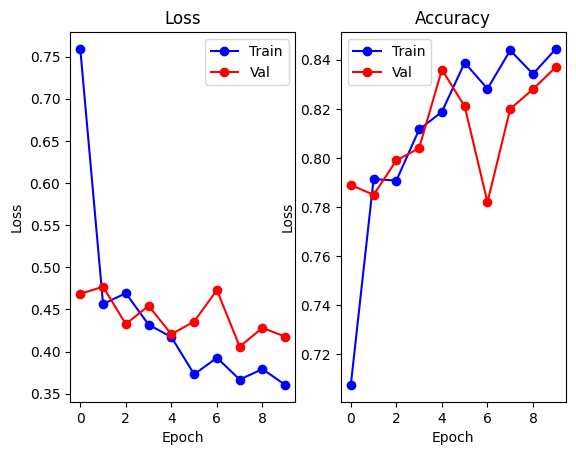

In [23]:
model1, epoch_loss1, epoch_acc1 = build_and_train_model(CNN_1().to(device), 10, 0.001, 
                                                        small_min_trans_data_loader)
plot_curve(epoch_loss1, epoch_acc1)
create_submission_file(model1, sub_data_loader, 'sub_1.csv') 

## Experiment 2

Train: Epoch [0], Loss: 0.5239, Accuracy: 0.7482
Valid: Epoch [0], Loss: 0.4812, Accuracy: 0.7910
Train: Epoch [1], Loss: 0.4721, Accuracy: 0.7834
Valid: Epoch [1], Loss: 0.4675, Accuracy: 0.7780
Train: Epoch [2], Loss: 0.4363, Accuracy: 0.8000
Valid: Epoch [2], Loss: 0.4320, Accuracy: 0.8040
Train: Epoch [3], Loss: 0.4170, Accuracy: 0.8130
Valid: Epoch [3], Loss: 0.4191, Accuracy: 0.8090
Train: Epoch [4], Loss: 0.4063, Accuracy: 0.8214
Valid: Epoch [4], Loss: 0.4182, Accuracy: 0.8130
Train: Epoch [5], Loss: 0.3864, Accuracy: 0.8328
Valid: Epoch [5], Loss: 0.4157, Accuracy: 0.8080
Train: Epoch [6], Loss: 0.3790, Accuracy: 0.8370
Valid: Epoch [6], Loss: 0.5201, Accuracy: 0.7400
Train: Epoch [7], Loss: 0.3861, Accuracy: 0.8250
Valid: Epoch [7], Loss: 0.3994, Accuracy: 0.8180
Train: Epoch [8], Loss: 0.3663, Accuracy: 0.8402
Valid: Epoch [8], Loss: 0.3874, Accuracy: 0.8300
Train: Epoch [9], Loss: 0.3648, Accuracy: 0.8434
Valid: Epoch [9], Loss: 0.3924, Accuracy: 0.8280


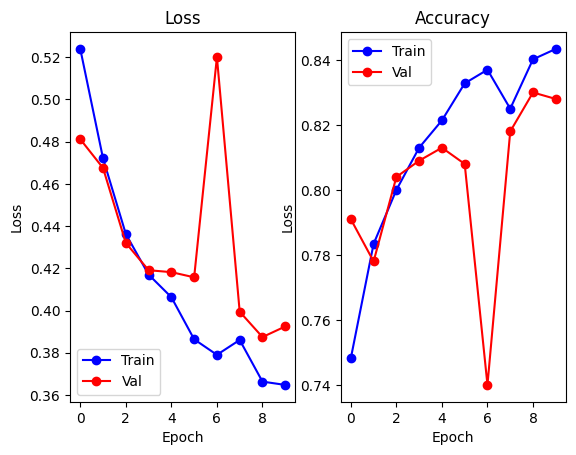

In [24]:
model2, epoch_loss2, epoch_acc2 = build_and_train_model(CNN_1().to(device), 10, 0.0001, 
                                                        small_min_trans_data_loader)
plot_curve(epoch_loss2, epoch_acc2)
create_submission_file(model2, sub_data_loader, 'sub_2.csv')

## Experiment 3

Train: Epoch [0], Loss: 0.6335, Accuracy: 0.7454
Valid: Epoch [0], Loss: 0.4901, Accuracy: 0.7850
Train: Epoch [1], Loss: 0.4309, Accuracy: 0.8072
Valid: Epoch [1], Loss: 0.4060, Accuracy: 0.8230
Train: Epoch [2], Loss: 0.4008, Accuracy: 0.8222
Valid: Epoch [2], Loss: 0.4091, Accuracy: 0.8250
Train: Epoch [3], Loss: 0.4051, Accuracy: 0.8176
Valid: Epoch [3], Loss: 0.5296, Accuracy: 0.7460
Train: Epoch [4], Loss: 0.4171, Accuracy: 0.8166
Valid: Epoch [4], Loss: 0.4688, Accuracy: 0.8200
Train: Epoch [5], Loss: 0.3711, Accuracy: 0.8414
Valid: Epoch [5], Loss: 0.6007, Accuracy: 0.7660
Train: Epoch [6], Loss: 0.4133, Accuracy: 0.8280
Valid: Epoch [6], Loss: 0.5460, Accuracy: 0.8060
Train: Epoch [7], Loss: 0.3667, Accuracy: 0.8434
Valid: Epoch [7], Loss: 0.3893, Accuracy: 0.8490
Train: Epoch [8], Loss: 0.3311, Accuracy: 0.8542
Valid: Epoch [8], Loss: 0.3928, Accuracy: 0.8480
Train: Epoch [9], Loss: 0.3364, Accuracy: 0.8610
Valid: Epoch [9], Loss: 0.3978, Accuracy: 0.8260


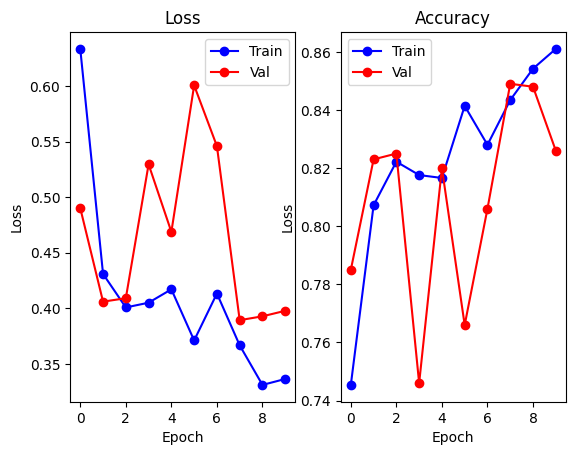

In [25]:
model3, epoch_loss3, epoch_acc3 = build_and_train_model(CNN_1().to(device), 10, 0.001, 
                                                        small_reco_trans_data_loader)
plot_curve(epoch_loss3, epoch_acc3) 
create_submission_file(model3, sub_data_loader, 'sub_3.csv')

## Experiment 4

Train: Epoch [0], Loss: 0.5202, Accuracy: 0.7492
Valid: Epoch [0], Loss: 0.4575, Accuracy: 0.7900
Train: Epoch [1], Loss: 0.4345, Accuracy: 0.8056
Valid: Epoch [1], Loss: 0.4072, Accuracy: 0.8210
Train: Epoch [2], Loss: 0.4071, Accuracy: 0.8196
Valid: Epoch [2], Loss: 0.4184, Accuracy: 0.8130
Train: Epoch [3], Loss: 0.3949, Accuracy: 0.8314
Valid: Epoch [3], Loss: 0.4101, Accuracy: 0.8140
Train: Epoch [4], Loss: 0.3910, Accuracy: 0.8252
Valid: Epoch [4], Loss: 0.3903, Accuracy: 0.8270
Train: Epoch [5], Loss: 0.3778, Accuracy: 0.8330
Valid: Epoch [5], Loss: 0.3882, Accuracy: 0.8260
Train: Epoch [6], Loss: 0.3598, Accuracy: 0.8422
Valid: Epoch [6], Loss: 0.4817, Accuracy: 0.7940
Train: Epoch [7], Loss: 0.3670, Accuracy: 0.8406
Valid: Epoch [7], Loss: 0.5197, Accuracy: 0.7760
Train: Epoch [8], Loss: 0.3489, Accuracy: 0.8468
Valid: Epoch [8], Loss: 0.3947, Accuracy: 0.8230
Train: Epoch [9], Loss: 0.3458, Accuracy: 0.8492
Valid: Epoch [9], Loss: 0.3830, Accuracy: 0.8290


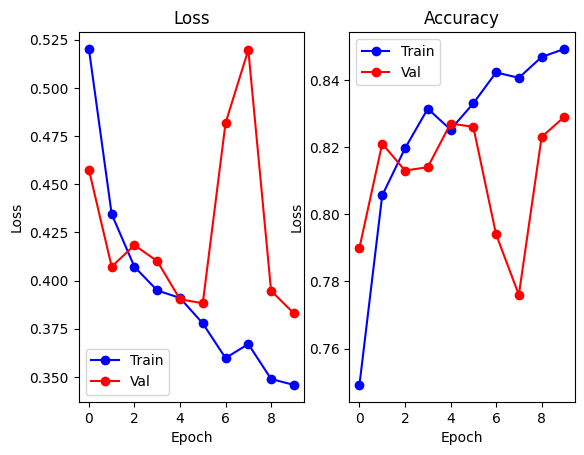

In [26]:
model4, epoch_loss4, epoch_acc4 = build_and_train_model(CNN_1().to(device), 10, 0.0001, 
                                                        small_reco_trans_data_loader)
plot_curve(epoch_loss4, epoch_acc4)
create_submission_file(model4, sub_data_loader, 'sub_4.csv')  


In [27]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.final = nn.Linear(1024*1*1, 2) # ***
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
        x = self.global_avg_pooling(x)
        #print("x.shape",x.shape)  # ***


        x = x.view(-1, 1024*1*1) # ***
        x = self.final(x)
        return x

## Experiment 5

Train: Epoch [0], Loss: 0.6965, Accuracy: 0.7328
Valid: Epoch [0], Loss: 0.6197, Accuracy: 0.7680
Train: Epoch [1], Loss: 0.4629, Accuracy: 0.7898
Valid: Epoch [1], Loss: 0.4905, Accuracy: 0.7860
Train: Epoch [2], Loss: 0.4441, Accuracy: 0.8028
Valid: Epoch [2], Loss: 0.4795, Accuracy: 0.8090
Train: Epoch [3], Loss: 0.4212, Accuracy: 0.8182
Valid: Epoch [3], Loss: 0.4265, Accuracy: 0.8080
Train: Epoch [4], Loss: 0.4050, Accuracy: 0.8224
Valid: Epoch [4], Loss: 0.7470, Accuracy: 0.6270
Train: Epoch [5], Loss: 0.4167, Accuracy: 0.8126
Valid: Epoch [5], Loss: 0.4491, Accuracy: 0.7930
Train: Epoch [6], Loss: 0.3969, Accuracy: 0.8242
Valid: Epoch [6], Loss: 0.3816, Accuracy: 0.8280
Train: Epoch [7], Loss: 0.3844, Accuracy: 0.8322
Valid: Epoch [7], Loss: 0.3557, Accuracy: 0.8540
Train: Epoch [8], Loss: 0.3643, Accuracy: 0.8420
Valid: Epoch [8], Loss: 0.4079, Accuracy: 0.8440
Train: Epoch [9], Loss: 0.3619, Accuracy: 0.8496
Valid: Epoch [9], Loss: 0.4789, Accuracy: 0.7920


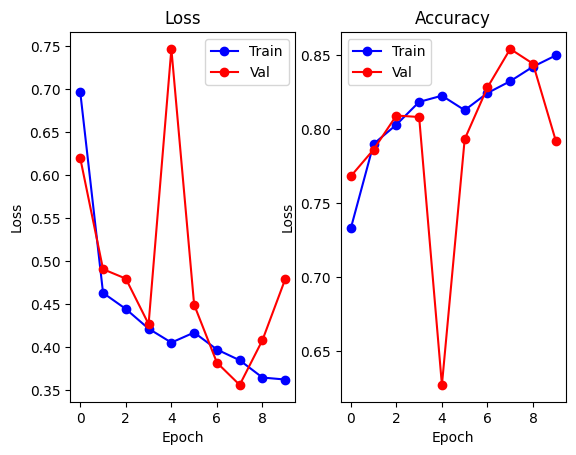

In [28]:
model5, epoch_loss5, epoch_acc5 = build_and_train_model(CNN_2().to(device), 10, 0.001, 
                                                        small_min_trans_data_loader)
plot_curve(epoch_loss5, epoch_acc5)
create_submission_file(model5, sub_data_loader, 'sub_5.csv') 

## Experiment 6

Train: Epoch [0], Loss: 0.4883, Accuracy: 0.7738
Valid: Epoch [0], Loss: 0.4232, Accuracy: 0.8080
Train: Epoch [1], Loss: 0.3976, Accuracy: 0.8238
Valid: Epoch [1], Loss: 1.5343, Accuracy: 0.5200
Train: Epoch [2], Loss: 0.3942, Accuracy: 0.8294
Valid: Epoch [2], Loss: 0.3936, Accuracy: 0.8270
Train: Epoch [3], Loss: 0.3116, Accuracy: 0.8706
Valid: Epoch [3], Loss: 0.7197, Accuracy: 0.7000
Train: Epoch [4], Loss: 0.2864, Accuracy: 0.8822
Valid: Epoch [4], Loss: 0.4811, Accuracy: 0.7920
Train: Epoch [5], Loss: 0.1791, Accuracy: 0.9400
Valid: Epoch [5], Loss: 0.6809, Accuracy: 0.7380
Train: Epoch [6], Loss: 0.1197, Accuracy: 0.9626
Valid: Epoch [6], Loss: 1.0641, Accuracy: 0.6470
Train: Epoch [7], Loss: 0.0850, Accuracy: 0.9742
Valid: Epoch [7], Loss: 0.4293, Accuracy: 0.8380
Train: Epoch [8], Loss: 0.0519, Accuracy: 0.9872
Valid: Epoch [8], Loss: 0.6338, Accuracy: 0.7650
Train: Epoch [9], Loss: 0.0407, Accuracy: 0.9906
Valid: Epoch [9], Loss: 0.4774, Accuracy: 0.8390


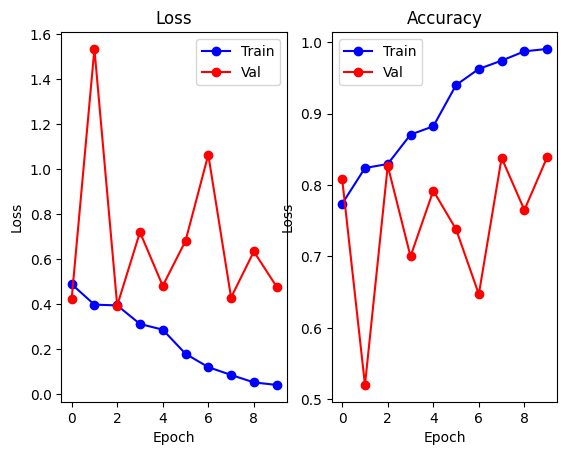

In [29]:
model6, epoch_loss6, epoch_acc6 = build_and_train_model(CNN_2().to(device), 10, 0.0001, 
                                                        small_min_trans_data_loader)
plot_curve(epoch_loss6, epoch_acc6)
create_submission_file(model6, sub_data_loader, 'sub_6.csv') 

## Experiment 7

Train: Epoch [0], Loss: 0.7203, Accuracy: 0.7448
Valid: Epoch [0], Loss: 0.4517, Accuracy: 0.7950
Train: Epoch [1], Loss: 0.4421, Accuracy: 0.8014
Valid: Epoch [1], Loss: 0.6885, Accuracy: 0.6310
Train: Epoch [2], Loss: 0.4334, Accuracy: 0.8106
Valid: Epoch [2], Loss: 0.4743, Accuracy: 0.7890
Train: Epoch [3], Loss: 0.4006, Accuracy: 0.8242
Valid: Epoch [3], Loss: 0.5387, Accuracy: 0.7790
Train: Epoch [4], Loss: 0.3914, Accuracy: 0.8290
Valid: Epoch [4], Loss: 0.3940, Accuracy: 0.8440
Train: Epoch [5], Loss: 0.3637, Accuracy: 0.8490
Valid: Epoch [5], Loss: 0.3796, Accuracy: 0.8410
Train: Epoch [6], Loss: 0.3624, Accuracy: 0.8454
Valid: Epoch [6], Loss: 0.3791, Accuracy: 0.8400
Train: Epoch [7], Loss: 0.3736, Accuracy: 0.8404
Valid: Epoch [7], Loss: 0.4549, Accuracy: 0.8100
Train: Epoch [8], Loss: 0.3381, Accuracy: 0.8592
Valid: Epoch [8], Loss: 0.4777, Accuracy: 0.8030
Train: Epoch [9], Loss: 0.3364, Accuracy: 0.8580
Valid: Epoch [9], Loss: 0.5300, Accuracy: 0.7740


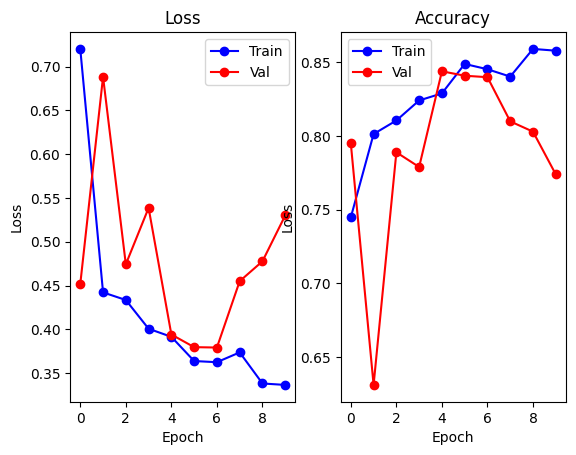

In [30]:
model7, epoch_loss7, epoch_acc7 = build_and_train_model(CNN_2().to(device), 10, 0.001, 
                                                        small_reco_trans_data_loader)
plot_curve(epoch_loss7, epoch_acc7)
create_submission_file(model7, sub_data_loader, 'sub_7.csv')  

## Experiment 8

Train: Epoch [0], Loss: 0.5563, Accuracy: 0.7522
Valid: Epoch [0], Loss: 0.4487, Accuracy: 0.7940
Train: Epoch [1], Loss: 0.4249, Accuracy: 0.8090
Valid: Epoch [1], Loss: 0.4144, Accuracy: 0.8110
Train: Epoch [2], Loss: 0.3773, Accuracy: 0.8346
Valid: Epoch [2], Loss: 0.3859, Accuracy: 0.8250
Train: Epoch [3], Loss: 0.3436, Accuracy: 0.8596
Valid: Epoch [3], Loss: 1.0906, Accuracy: 0.5860
Train: Epoch [4], Loss: 0.3147, Accuracy: 0.8716
Valid: Epoch [4], Loss: 0.4415, Accuracy: 0.8170
Train: Epoch [5], Loss: 0.3129, Accuracy: 0.8662
Valid: Epoch [5], Loss: 0.4266, Accuracy: 0.8170
Train: Epoch [6], Loss: 0.2619, Accuracy: 0.8938
Valid: Epoch [6], Loss: 0.5274, Accuracy: 0.7890
Train: Epoch [7], Loss: 0.1463, Accuracy: 0.9574
Valid: Epoch [7], Loss: 0.5178, Accuracy: 0.8130
Train: Epoch [8], Loss: 0.0911, Accuracy: 0.9748
Valid: Epoch [8], Loss: 0.5653, Accuracy: 0.8060
Train: Epoch [9], Loss: 0.0754, Accuracy: 0.9800
Valid: Epoch [9], Loss: 1.4050, Accuracy: 0.6250


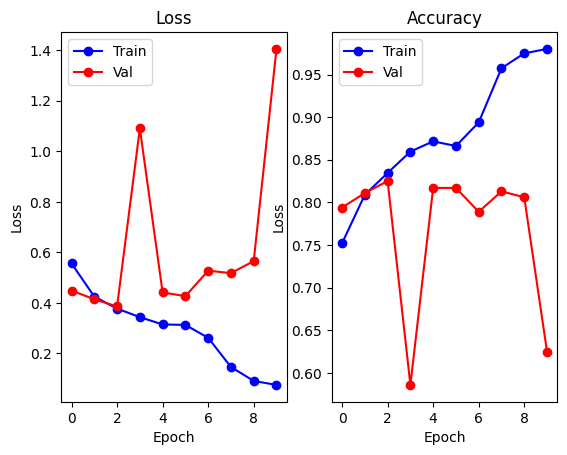

In [31]:
model8, epoch_loss8, epoch_acc8 = build_and_train_model(CNN_2().to(device), 10, 0.0001, 
                                                        small_reco_trans_data_loader)
plot_curve(epoch_loss8, epoch_acc8)
create_submission_file(model8, sub_data_loader, 'sub_8.csv')  

## Experiment 9

Train: Epoch [0], Loss: 0.3287, Accuracy: 0.8623
Valid: Epoch [0], Loss: 0.4287, Accuracy: 0.8096
Train: Epoch [1], Loss: 0.2131, Accuracy: 0.9175
Valid: Epoch [1], Loss: 0.2261, Accuracy: 0.9103
Train: Epoch [2], Loss: 0.1739, Accuracy: 0.9346
Valid: Epoch [2], Loss: 0.2741, Accuracy: 0.8951
Train: Epoch [3], Loss: 0.1510, Accuracy: 0.9444
Valid: Epoch [3], Loss: 0.2321, Accuracy: 0.9083
Train: Epoch [4], Loss: 0.1338, Accuracy: 0.9512
Valid: Epoch [4], Loss: 0.1453, Accuracy: 0.9454
Train: Epoch [5], Loss: 0.1168, Accuracy: 0.9580
Valid: Epoch [5], Loss: 0.1792, Accuracy: 0.9304
Train: Epoch [6], Loss: 0.1008, Accuracy: 0.9638
Valid: Epoch [6], Loss: 0.1647, Accuracy: 0.9411
Train: Epoch [7], Loss: 0.0854, Accuracy: 0.9691
Valid: Epoch [7], Loss: 0.1258, Accuracy: 0.9565
Train: Epoch [8], Loss: 0.0732, Accuracy: 0.9739
Valid: Epoch [8], Loss: 0.1287, Accuracy: 0.9560
Train: Epoch [9], Loss: 0.0586, Accuracy: 0.9792
Valid: Epoch [9], Loss: 0.1734, Accuracy: 0.9492


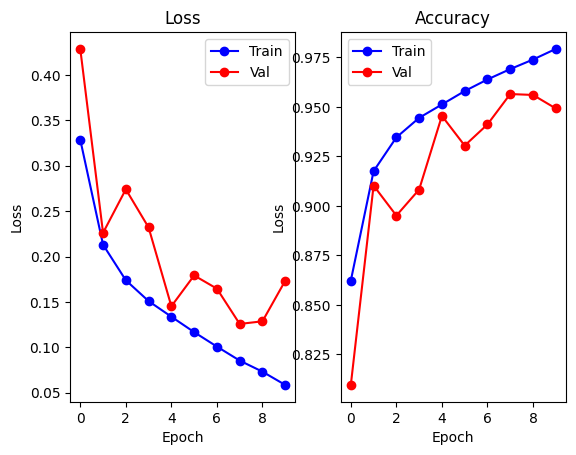

In [32]:
model9, epoch_loss9, epoch_acc9 = build_and_train_model(CNN_2().to(device), 10, 0.001, 
                                                        full_min_trans_data_loader)
plot_curve(epoch_loss9, epoch_acc9)
create_submission_file(model9, sub_data_loader, 'sub_9.csv')

## Experiment 10

Train: Epoch [0], Loss: 0.3244, Accuracy: 0.8628
Valid: Epoch [0], Loss: 0.5824, Accuracy: 0.7989
Train: Epoch [1], Loss: 0.2258, Accuracy: 0.9099
Valid: Epoch [1], Loss: 0.3229, Accuracy: 0.8695
Train: Epoch [2], Loss: 0.1847, Accuracy: 0.9286
Valid: Epoch [2], Loss: 0.2653, Accuracy: 0.8943
Train: Epoch [3], Loss: 0.1510, Accuracy: 0.9426
Valid: Epoch [3], Loss: 0.3149, Accuracy: 0.8888
Train: Epoch [4], Loss: 0.1229, Accuracy: 0.9548
Valid: Epoch [4], Loss: 0.2264, Accuracy: 0.9232
Train: Epoch [5], Loss: 0.0970, Accuracy: 0.9643
Valid: Epoch [5], Loss: 0.2729, Accuracy: 0.9155
Train: Epoch [6], Loss: 0.0695, Accuracy: 0.9748
Valid: Epoch [6], Loss: 0.2039, Accuracy: 0.9236
Train: Epoch [7], Loss: 0.0502, Accuracy: 0.9821
Valid: Epoch [7], Loss: 0.2414, Accuracy: 0.9285
Train: Epoch [8], Loss: 0.0395, Accuracy: 0.9862
Valid: Epoch [8], Loss: 0.3180, Accuracy: 0.9178
Train: Epoch [9], Loss: 0.0319, Accuracy: 0.9888
Valid: Epoch [9], Loss: 0.2801, Accuracy: 0.9271


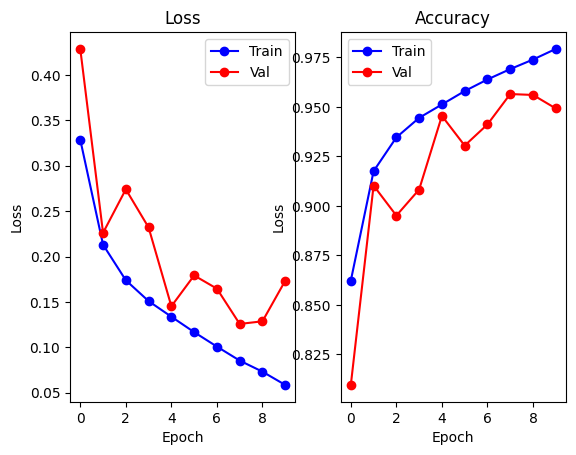

In [33]:
model10, epoch_loss10, epoch_acc10 = build_and_train_model(CNN_2().to(device), 10, 0.0001, 
                                                        full_min_trans_data_loader)
plot_curve(epoch_loss9, epoch_acc9)
create_submission_file(model9, sub_data_loader, 'sub_10.csv')

## Experiment 11

Train: Epoch [0], Loss: 0.3351, Accuracy: 0.8594
Valid: Epoch [0], Loss: 0.2500, Accuracy: 0.8997
Train: Epoch [1], Loss: 0.2138, Accuracy: 0.9169
Valid: Epoch [1], Loss: 0.6113, Accuracy: 0.7886
Train: Epoch [2], Loss: 0.1737, Accuracy: 0.9346
Valid: Epoch [2], Loss: 0.1850, Accuracy: 0.9288
Train: Epoch [3], Loss: 0.1500, Accuracy: 0.9444
Valid: Epoch [3], Loss: 0.1502, Accuracy: 0.9436
Train: Epoch [4], Loss: 0.1314, Accuracy: 0.9514
Valid: Epoch [4], Loss: 0.2388, Accuracy: 0.9228
Train: Epoch [5], Loss: 0.1144, Accuracy: 0.9589
Valid: Epoch [5], Loss: 0.3502, Accuracy: 0.8732
Train: Epoch [6], Loss: 0.0988, Accuracy: 0.9647
Valid: Epoch [6], Loss: 0.1615, Accuracy: 0.9399
Train: Epoch [7], Loss: 0.0855, Accuracy: 0.9700
Valid: Epoch [7], Loss: 0.1632, Accuracy: 0.9437
Train: Epoch [8], Loss: 0.0711, Accuracy: 0.9747
Valid: Epoch [8], Loss: 0.1399, Accuracy: 0.9498
Train: Epoch [9], Loss: 0.0581, Accuracy: 0.9794
Valid: Epoch [9], Loss: 0.1732, Accuracy: 0.9373


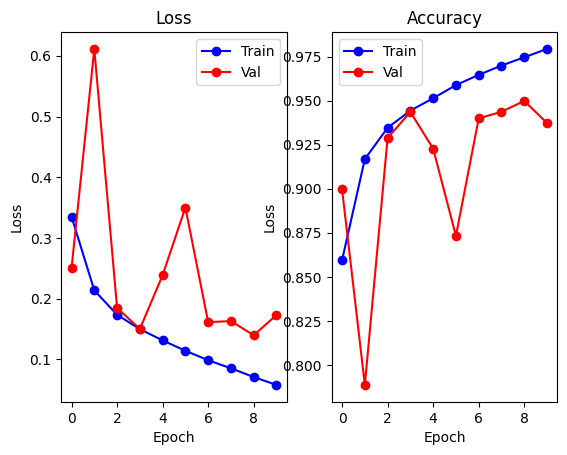

In [34]:
model11, epoch_loss11, epoch_acc11 = build_and_train_model(CNN_2().to(device), 10, 0.001, 
                                                        full_reco_trans_data_loader)
plot_curve(epoch_loss11, epoch_acc11)
create_submission_file(model11, sub_data_loader, 'sub_11.csv') 

## Experiment 12

Train: Epoch [0], Loss: 0.3321, Accuracy: 0.8586
Valid: Epoch [0], Loss: 0.3616, Accuracy: 0.8427
Train: Epoch [1], Loss: 0.2358, Accuracy: 0.9056
Valid: Epoch [1], Loss: 0.2335, Accuracy: 0.9073
Train: Epoch [2], Loss: 0.1923, Accuracy: 0.9255
Valid: Epoch [2], Loss: 0.4782, Accuracy: 0.8321
Train: Epoch [3], Loss: 0.1586, Accuracy: 0.9402
Valid: Epoch [3], Loss: 0.1829, Accuracy: 0.9271
Train: Epoch [4], Loss: 0.1310, Accuracy: 0.9521
Valid: Epoch [4], Loss: 0.1728, Accuracy: 0.9330
Train: Epoch [5], Loss: 0.1081, Accuracy: 0.9604
Valid: Epoch [5], Loss: 0.1480, Accuracy: 0.9449
Train: Epoch [6], Loss: 0.0814, Accuracy: 0.9707
Valid: Epoch [6], Loss: 0.3355, Accuracy: 0.8879
Train: Epoch [7], Loss: 0.0600, Accuracy: 0.9787
Valid: Epoch [7], Loss: 0.2916, Accuracy: 0.9122
Train: Epoch [8], Loss: 0.0479, Accuracy: 0.9829
Valid: Epoch [8], Loss: 0.2377, Accuracy: 0.9299
Train: Epoch [9], Loss: 0.0366, Accuracy: 0.9867
Valid: Epoch [9], Loss: 0.4430, Accuracy: 0.8858


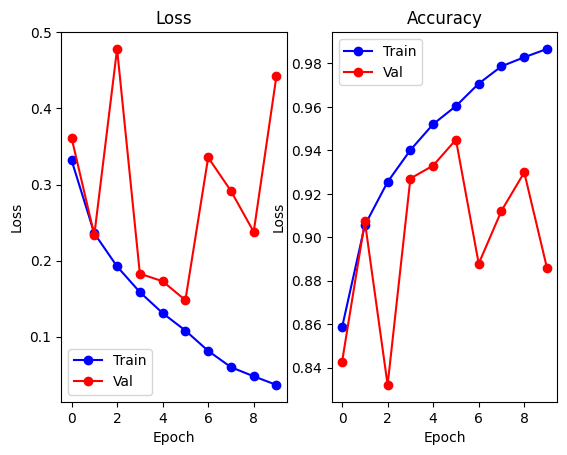

In [35]:
model12, epoch_loss12, epoch_acc12 = build_and_train_model(CNN_2().to(device), 10, 0.0001, 
                                                        full_reco_trans_data_loader)
plot_curve(epoch_loss12, epoch_acc12)
create_submission_file(model12, sub_data_loader, 'sub_12.csv')  


## Experiment Summary and Analysis

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-0lax">Experiment ID</th>
    <th class="tg-0lax">Model </th>
    <th class="tg-0lax">Training Acc</th>
    <th class="tg-0lax">Valid Acc</th>
    <th class="tg-0lax">Kaggle Private Score</th>
    <th class="tg-0lax">Best Epoch</th>
    <th class="tg-0lax">Best Train Acc</th>
    <th class="tg-0lax">Best Valid Acc</th>
    <th class="tg-0lax">Data Size</th>
    <th class="tg-0lax">Data Aug</th>
    <th class="tg-0lax">Learning Rate</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-0lax">11</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">97.94%</td>
    <td class="tg-0lax">93.73%</td>
    <td class="tg-0lax">92.65%</td>
    <td class="tg-0lax">8</td>
    <td class="tg-0lax">97.47%</td>
    <td class="tg-0lax">94.98%</td>
    <td class="tg-0lax">1760.20</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.001</td>
  </tr>
  <tr>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">97.92%</td>
    <td class="tg-0lax">94.92%</td>
    <td class="tg-0lax">92.56%</td>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">0.9792</td>
    <td class="tg-0lax">0.9492</td>
    <td class="tg-0lax">1760.20</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.001</td>
  </tr>
  <tr>
    <td class="tg-0lax">10</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">98.88%</td>
    <td class="tg-0lax">92.70%</td>
    <td class="tg-0lax">92.56%</td>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">0.9888</td>
    <td class="tg-0lax">0.927</td>
    <td class="tg-0lax">1760.20</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">12</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">98.67%</td>
    <td class="tg-0lax">88.58%</td>
    <td class="tg-0lax">91.83%</td>
    <td class="tg-0lax">7</td>
    <td class="tg-0lax">98.29%</td>
    <td class="tg-0lax">92.99%</td>
    <td class="tg-0lax">1760.20</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">7</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">85.80%</td>
    <td class="tg-0lax">77.40%</td>
    <td class="tg-0lax">87.47%</td>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">84.90%</td>
    <td class="tg-0lax">84.10%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.001</td>
  </tr>
  <tr>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">84.96%</td>
    <td class="tg-0lax">79.20%</td>
    <td class="tg-0lax">86.52%</td>
    <td class="tg-0lax">8</td>
    <td class="tg-0lax">84.20%</td>
    <td class="tg-0lax">84.40%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.001</td>
  </tr>
  <tr>
    <td class="tg-0lax">6</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">99.06%</td>
    <td class="tg-0lax">83.90%</td>
    <td class="tg-0lax">84.84%</td>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">99.06%</td>
    <td class="tg-0lax">83.90%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax">CNN_1</td>
    <td class="tg-0lax">84.92%</td>
    <td class="tg-0lax">82.90%</td>
    <td class="tg-0lax">84.14%</td>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">84.92%</td>
    <td class="tg-0lax">82.90%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax">CNN_1</td>
    <td class="tg-0lax">86.10%</td>
    <td class="tg-0lax">82.60%</td>
    <td class="tg-0lax">81.02%</td>
    <td class="tg-0lax">8</td>
    <td class="tg-0lax">85.42%</td>
    <td class="tg-0lax">84.80%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.001</td>
  </tr>
  <tr>
    <td class="tg-0lax">8</td>
    <td class="tg-0lax">CNN_2</td>
    <td class="tg-0lax">98.00%</td>
    <td class="tg-0lax">62.50%</td>
    <td class="tg-0lax">80.26%</td>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax">87.16%</td>
    <td class="tg-0lax">81.70%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">Y</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">CNN_1</td>
    <td class="tg-0lax">84.34%</td>
    <td class="tg-0lax">82.80%</td>
    <td class="tg-0lax">80.07%</td>
    <td class="tg-0lax">8</td>
    <td class="tg-0lax">84.04%</td>
    <td class="tg-0lax">83.99%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.0001</td>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax">CNN_1</td>
    <td class="tg-0lax">84.44%</td>
    <td class="tg-0lax">83.70%</td>
    <td class="tg-0lax">79.46%</td>
    <td class="tg-0lax">9</td>
    <td class="tg-0lax">84.44%</td>
    <td class="tg-0lax">83.70%</td>
    <td class="tg-0lax">5000.00</td>
    <td class="tg-0lax">N</td>
    <td class="tg-0lax">0.001</td>
  </tr>
</tbody></table>



The best performing model is the one from Experiment 11. It yields a Kaggle Private score of 92.65%. It uses the CNN_2 which has a higher cacpacity than CNN_1, augmented data, the full training data set (not surprising), and a learning rate of 0.001. From the table, you can see that CNN_2 architecture outperforms the CNN_1 architecture. While the results show that the pytorch recommended data augmentation does improve accuracy, it not be a large amount. Perhaps more data augmentation would better improve the results and could form the basis for further experiments. Generally, the lower learning rate performs better. Trying a learning rate of 0.01 would be interesting but not in scope for this mini-project. 

The table shows for each model which is the best training Epoch. This is somewhat subjective and is based on looking at the trend of distance beteween training accuracy and validation accuracy (as well as loss size). The the trend shows that the distance keeps increasing, then there is likely overfitting and the training should stop early. This is further validated by looking at the Kaggle Private Score for the given run. If it is The table shows that stoping early would likely benefit the models, but this is may not be the case for the best performing model given the graph shown in Experiment 11 because there are not enough epochs to indicate it the distance between training accuracy and validation accuracy is continously getting larger. It might be possible that this model could further improve with more Epochs.

# Conclusion

This project used CNNs built using PyTorch to perform cancer detection on cancer images. Two model architectures where used, one with 3 hidden layers and the other using 6 hidden layers. Both MaxPooling and Global Average Pooling where used.

Since training time is very long using the full data set (it can take 3-4 hours to traing one model / run one experiment), a number of experiments where first run using smaller training data sets. Both unaugmented data and augmented data were used to see if there were differences in performance as well as two different learning rates. All experiments used 10 training epochs. A stride size of 2 was consistently selected to help reduce training time.

The generaly conclusion is that a smaller learning rate, augmented data, higher capacity model architecture (i.e. more layers) and more training data yielded better performance. If there was more time to run more experiments or access to high power GPUs, it would have been ideal to run more experiments with a smaller learning rate, different data augmentation techniques, and adjusting stride to both a smaller and larger size.
